In [2]:
import pandas as pd
import numpy as np
import os
import csv
import sys
import swifter

csv.field_size_limit(100000000)

100000000

# Importing Dataset from Kaggle and FakeNewsCorpus 
# With Cleaning

In [4]:
kaggle_csv = pd.read_csv('./work/Datasets/Combined_Dataset/combined_data.csv', usecols=['domain', 'label'])
kaggle_csv.head(2)

,label,domain
0,reliable,bbc.com
1,reliable,reuters.com


In [8]:
corpus_csv = pd.read_csv('./work/Datasets/FakeNewsCorpusTrimmed/cleaned_data_domain.csv', usecols=['domain', 'type'])
corpus_csv.columns = ['label', 'domain']
corpus_csv.head(2)

,label,domain
0,fake,beforeitsnews.com
1,fake,beforeitsnews.com


In [9]:
combined_domain_df = pd.concat([corpus_csv, kaggle_csv])
combined_domain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469371 entries, 0 to 4008
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   domain  object
dtypes: object(2)
memory usage: 102.3+ MB


In [10]:
combined_domain_df = combined_domain_df.dropna()
combined_domain_df.reset_index(drop=True, inplace=True)

combined_domain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4469371 entries, 0 to 4469370
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   domain  object
dtypes: object(2)
memory usage: 68.2+ MB


In [18]:
combined_domain_df.label.unique()

array(['fake', 'reliable', 'political', 'type'], dtype=object)

In [19]:
combined_domain_df = combined_domain_df[combined_domain_df.label != 'type']

label_dict = {
    'political': 'reliable',
    'bias': 'fake',
    'unreliable': 'fake',
    'reliable': 'reliable',
    'fake': 'fake'
}


combined_domain_df['label'] = combined_domain_df['label'].swifter.apply(lambda x: label_dict[x])

combined_domain_df

Pandas Apply:   0%|          | 0/4469201 [00:00<?, ?it/s]

<ipython-input-19-10de718e3e3e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_domain_df['label'] = combined_domain_df['label'].swifter.apply(lambda x: label_dict[x])


,label,domain
0,fake,beforeitsnews.com
1,fake,beforeitsnews.com
2,fake,beforeitsnews.com
3,fake,beforeitsnews.com
4,fake,beforeitsnews.com
...,...,...
4469366,fake,beforeitsnews.com
4469367,fake,beforeitsnews.com
4469368,fake,activistpost.com
4469369,reliable,reuters.com


In [20]:
combined_domain_df.to_csv('./work/Datasets/Combined_Dataset/processed_domain.csv', mode='a', index=False)

print("Done Saving")

Done Saving


# Modeling

In [21]:
import matplotlib.pyplot as plt
import itertools

# Applying confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
# Removing duplicates from the dataframe
combined_domain_df.drop_duplicates(subset=['domain'], inplace=True)
combined_domain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 4469126
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   253 non-null    object
 1   domain  253 non-null    string
dtypes: object(1), string(1)
memory usage: 5.9+ KB


In [22]:
combined_domain_df['domain'] = combined_domain_df['domain'].astype('string')
combined_domain_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4469201 entries, 0 to 4469370
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   object
 1   domain  string
dtypes: object(1), string(1)
memory usage: 231.3+ MB
<ipython-input-22-666f9de99195>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_domain_df['domain'] = combined_domain_df['domain'].astype('string')


In [41]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(combined_domain_df, test_size=0.3, random_state=42)

train_df

,label,domain
1073567,fake,newsfrompolitics.com
2592570,reliable,sports.yahoo.com
633229,fake,freedomdaily.com
8914,reliable,counterpunch.org
2584954,reliable,ca.news.yahoo.com
...,...,...
1073374,fake,dailyheadlines.com
1914,reliable,weeklystandard.com
633514,fake,usanewsflash.com
2584748,reliable,www.cnet.com


In [42]:
X_train = train_df['domain']
Y_train = train_df['label']
X_test = test_df['domain']
Y_test = test_df['label']

## Naive Bayes Clasisfier with TF-IDF Vectorizer

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

bayes_model = Pipeline([('tfidf', TfidfVectorizer(max_features=5000,ngram_range=(1,3))), ('bayes', MultinomialNB())])

In [44]:
bayes_model = bayes_model.fit(X_train, Y_train)

Accuracy:    0.5394736842105263
Confusion matrix, without normalization


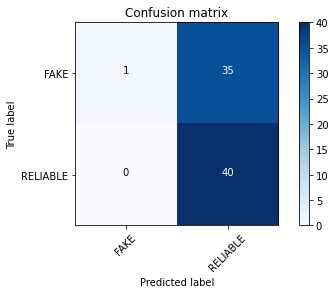

In [45]:
from sklearn import metrics

pred = bayes_model.predict(X_test)
score = metrics.accuracy_score(Y_test, pred)
print("Accuracy:   ", score)
cm = metrics.confusion_matrix(Y_test, pred)
plot_confusion_matrix(cm, classes=['FAKE', 'RELIABLE'])

## Linear SVM with SGDClassifier wtih TF-IDF Vectorizer

In [46]:
from sklearn.linear_model import SGDClassifier
svm_model = Pipeline([('tfidf', TfidfVectorizer(max_features=5000,ngram_range=(1,3))), ('svm', SGDClassifier(loss='hinge', alpha=1e-3, penalty='l2', random_state=42))])
svm_model = svm_model.fit(X_train, Y_train)

Accuracy:  0.5394736842105263
Confusion matrix, without normalization


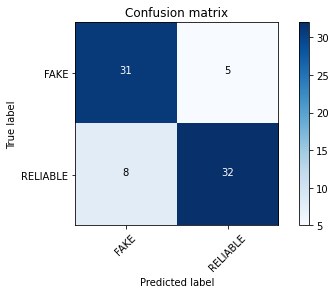

In [47]:
svm_pred = svm_model.predict(X_test)
svm_score = metrics.accuracy_score(Y_test, pred)
print("Accuracy: ", svm_score)
svm_cm = metrics.confusion_matrix(Y_test, svm_pred)
plot_confusion_matrix(svm_cm, classes=['FAKE', 'RELIABLE'])

## Passive Aggressive Classifier with TF-IDF Vectorizer

In [48]:
from sklearn.linear_model import PassiveAggressiveClassifier
pa_model = Pipeline([('tfidf', TfidfVectorizer(max_features=5000,ngram_range=(1,3))), ('passive_aggressive', PassiveAggressiveClassifier(n_iter_no_change=50))])

Accuracy:  0.8289473684210527
Confusion matrix, without normalization


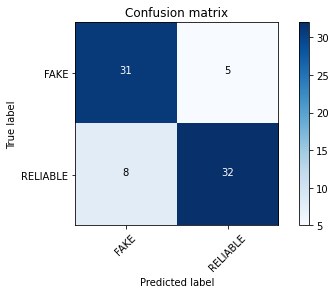

In [49]:
pa_model.fit(X_train, Y_train)
pa_pred = pa_model.predict(X_test)
pa_score = metrics.accuracy_score(Y_test, pa_pred)
print("Accuracy: ", pa_score)
pa_cm = metrics.confusion_matrix(Y_test, pa_pred)
plot_confusion_matrix(pa_cm, classes=['FAKE', 'RELIABLE'])

### Variations to PassiveAggressive Classifier
- Using 'squared_hinge' for loss instead of 'hinge'

In [50]:
from sklearn.linear_model import PassiveAggressiveClassifier

pa_model_test = Pipeline([('tfidf', TfidfVectorizer(max_features=5000,ngram_range=(1,3))), ('passive_aggressive', PassiveAggressiveClassifier(n_iter_no_change=50, loss='squared_hinge'))])

Accuracy:  0.8289473684210527
Confusion matrix, without normalization


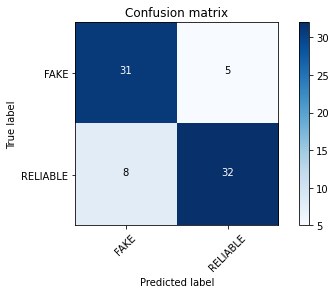

In [51]:
pa_model_test.fit(X_train, Y_train)
pa_pred_test = pa_model_test.predict(X_test)
pa_score_test = metrics.accuracy_score(Y_test, pa_pred_test)
print("Accuracy: ", pa_score_test)
pa_cm_test = metrics.confusion_matrix(Y_test, pa_pred_test)
plot_confusion_matrix(pa_cm_test, classes=['FAKE', 'RELIABLE'])

# Saving the model

In [52]:
import pickle

filename = 'combined_domain_pa_model.sav'
pickle.dump(pa_model, open(filename, 'wb'))